In [156]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize

### Cleaning of General Data

In [157]:
# Set research-based constants
scc = 51 # $51 damages are caused per ton of CO2 emissions

# Import electricity generation data
elec_gen = pd.read_csv('raw/electric_gen.csv')
emissions = pd.read_csv('raw/co2_emissions_from_energy_consumption.csv')
elec_cost = pd.read_csv('raw/electric_cost.csv')

# Only keep desired rows
elec_gen = elec_gen[elec_gen.Column_Order == 9]
emissions = emissions[emissions.Column_Order == 14]
elec_cost = elec_cost[elec_cost.Column_Order == 6]

# Only keep rows with valid dates
elec_gen["YYYYMM"] = elec_gen.apply(lambda row : str(row["YYYYMM"]), axis=1)
elec_gen = elec_gen[elec_gen["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]

emissions["YYYYMM"] = emissions.apply(lambda row : str(row["YYYYMM"]), axis=1)
emissions = emissions[emissions["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]

elec_cost["YYYYMM"] = elec_cost.apply(lambda row : str(row["YYYYMM"]), axis=1)
elec_cost = elec_cost[elec_cost["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]

# Convert string to date
elec_gen["Date"] = elec_gen.apply(lambda row : datetime.strptime(str(row["YYYYMM"]).strip(), "%Y%m"), axis=1)
emissions["Date"] = emissions.apply(lambda row : datetime.strptime(str(row["YYYYMM"]).strip(), "%Y%m"), axis=1)
elec_cost["Date"] = elec_cost.apply(lambda row : datetime.strptime(str(row["YYYYMM"]).strip(), "%Y%m"), axis=1)

# Drop unneeded columns
elec_gen.drop(["YYYYMM", "MSN", "Column_Order", "Description", "Unit"], axis=1, inplace=True)
emissions.drop(["YYYYMM", "MSN", "Column_Order", "Description", "Unit"], axis=1, inplace=True)
elec_cost.drop(["YYYYMM", "MSN", "Column_Order", "Description", "Unit"], axis=1, inplace=True)

# Drop NaN values
elec_cost = elec_cost[pd.to_numeric(elec_cost["Value"], errors="coerce").notnull()]

# Drop values from before 2000 (no cryptocurrencies invented until 2008)
starttime = datetime(2000, 1, 1)
elec_gen = elec_gen[elec_gen["Date"] > starttime]
emissions = emissions[emissions["Date"] > starttime]
elec_cost = elec_cost[elec_cost["Date"] > starttime]

# Convert values to kWh, Metric Tons of CO2, and Dollars per kWh, respectively
elec_gen["Gen [kWh]"] = elec_gen.apply(lambda row : (float(row["Value"]) * 1000000000), axis=1)
emissions["Emissions [Metric Tons CO2]"] = emissions.apply(lambda row : (float(row["Value"]) * 1000000), axis=1)
elec_cost["Cost [USD per kWh]"] = elec_cost.apply(lambda row : (float(row["Value"]) / 100), axis=1)

elec_gen.reset_index(inplace=True)
emissions.reset_index(inplace=True)
elec_cost.reset_index(inplace=True)

/tmp/ipykernel_77551/400253065.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  elec_gen = elec_gen[elec_gen["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]
/tmp/ipykernel_77551/400253065.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  emissions = emissions[emissions["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]
/tmp/ipykernel_77551/400253065.py:22: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  elec_cost = elec_cost[elec_cost["YYYYMM"].str.contains("[1-2][0-9][0-9][0-9](1[0-2]|0[1-9])")]


In [158]:
# Calculate emissions per kWh of energy produced
elec_emissions = pd.DataFrame()
elec_emissions["Energy Emissions (Metric Tons CO2 / kWh)"] = emissions["Emissions [Metric Tons CO2]"] / elec_gen["Gen [kWh]"]
elec_emissions["Date"] = emissions["Date"]

### Visualizations of General Data

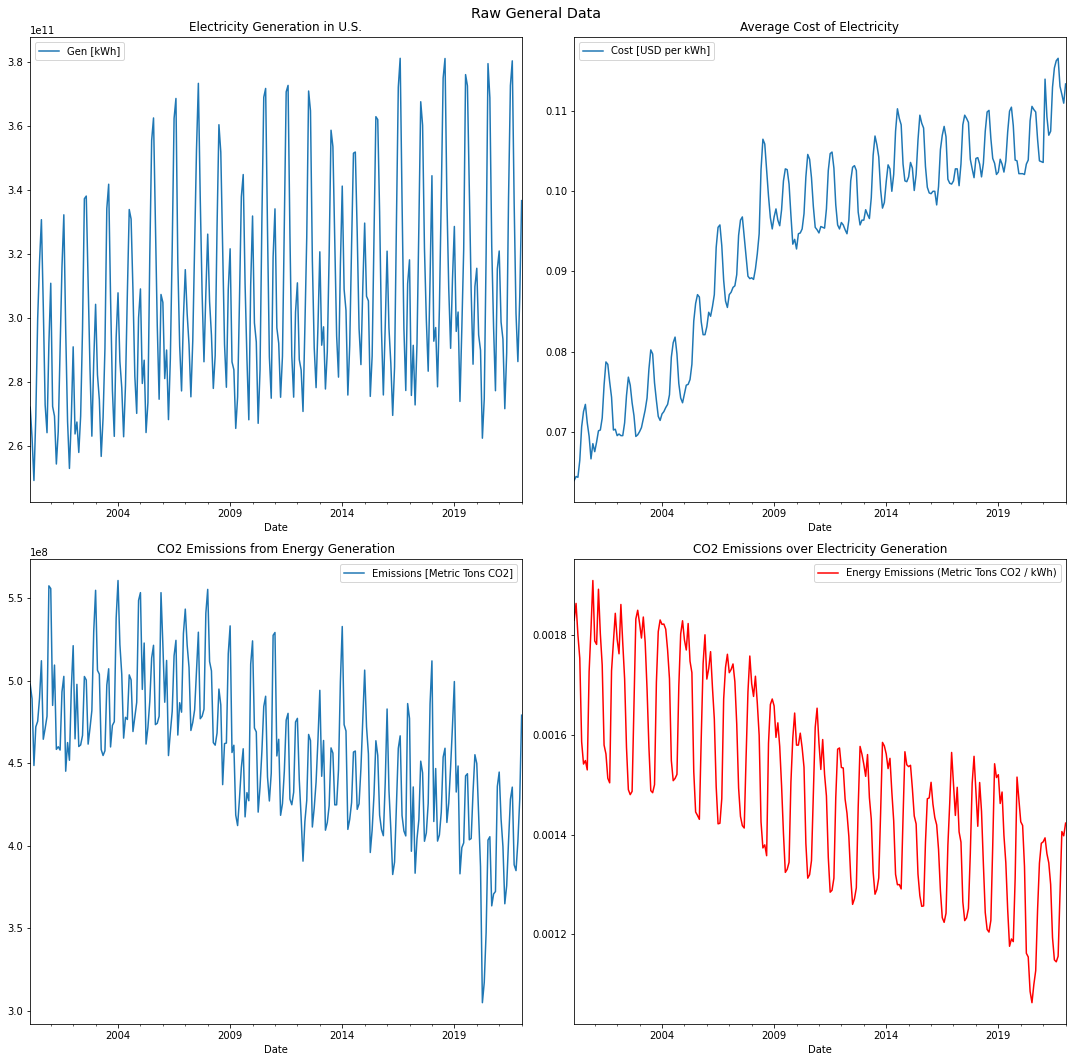

In [159]:
# Visualizations of raw general data
fig, axes = plt.subplots(2, 2, figsize=(15,15))
plt.suptitle("Raw General Data", size='x-large')
elec_gen.plot(ax=axes[0, 0], x="Date", y="Gen [kWh]", kind="line", title="Electricity Generation in U.S.")
emissions.plot(ax=axes[1, 0],x="Date", y="Emissions [Metric Tons CO2]", kind="line", title="CO2 Emissions from Energy Generation")
elec_cost.plot(ax=axes[0, 1],x="Date", y="Cost [USD per kWh]", kind="line", title="Average Cost of Electricity")
elec_emissions.plot(ax=axes[1, 1], x="Date", y="Energy Emissions (Metric Tons CO2 / kWh)", kind="line", title="CO2 Emissions over Electricity Generation", color="red")
fig.tight_layout()
plt.show()

### Cleaning of Coins Pricing Data

In [160]:
# Import data for each coin
nano = pd.read_csv("raw/xno_pricing.csv")
cardano = pd.read_csv("raw/ada_pricing.csv")
algorand = pd.read_csv("raw/algo_pricing.csv")
solana = pd.read_csv("raw/sol_pricing.csv")
hedera = pd.read_csv("raw/hbar_pricing.csv")

# Set names
nano.name="Nano"
cardano.name="Cardano"
algorand.name="Algorand"
solana.name="Solana"
hedera.name="Hedera"

coins_dfs = [nano, cardano, algorand, solana, hedera]

# Clean each dataframe
for index, coin in enumerate(coins_dfs):
    # Convert string to date
    coin["Date"] = coin.apply(lambda row: datetime.strptime(
        str(row["snapped_at"]).strip(), "%Y-%m-%d %H:%M:%S %Z"), axis=1)
    
    # Rename column
    coin["Price (USD)"] = coin["price"]

    # We are interested in price per coin, not market cap or volume
    coin.drop(["snapped_at", "price", "market_cap", "total_volume"], axis=1, inplace=True)

    # We want coin pricing per month
    newDf = coin.resample('M', on="Date").mean().reset_index()
    coin["Price (USD)"] = newDf["Price (USD)"]
    coin["Date"] = newDf["Date"]
    coin.dropna(inplace=True)

### Visualizations of Coin Pricing Data

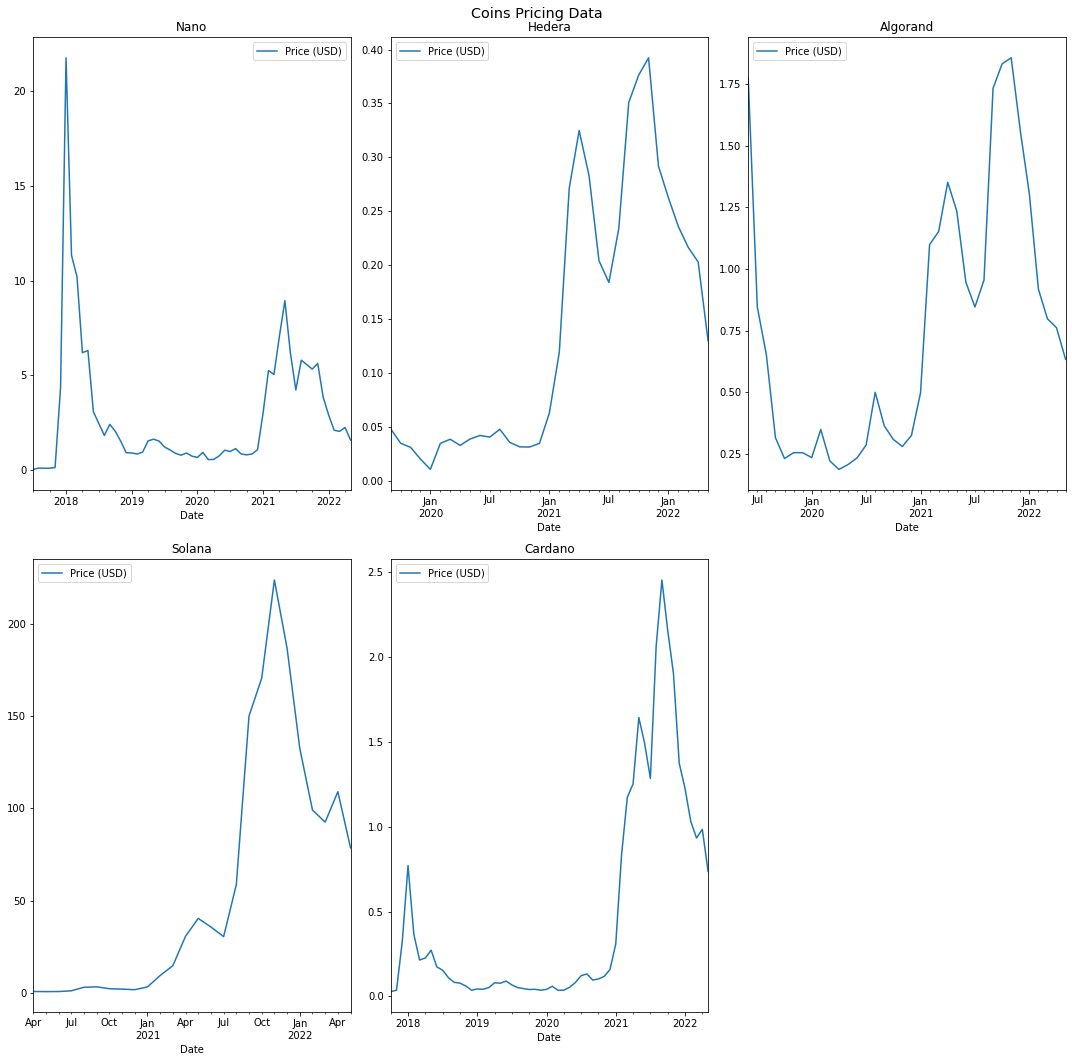

In [161]:
# Visualizations of coins pricing data
fig, axes = plt.subplots(2, 3, figsize=(15,15))
plt.suptitle("Coins Pricing Data", size='x-large')
for index, coin in enumerate(coins_dfs):
    coin.plot(ax=axes[index % 2, index % 3], x="Date", y="Price (USD)", kind="line", title=coin.name)
axes[1, 2].set_visible(False)
fig.tight_layout()
plt.show()

### Prepare Coins Energy Data

In [162]:
# GOALS IN THIS CELL - 
#   Set kwh_per_tx for each coin (energy in kwh used per transaction)
#   Set tx_per_day for each coin (transactions performed per day)
#   Set kwh_per_day for each coin (energy in kwh used per day)

# Nano
nano.kwh_per_tx = 0.000112
nano.tx_per_day = 80000

# Cardano
cardano.tx_per_day = 100000
cardano.kwh_per_tx = 0.5479

# Algorand
algorand.kwh_per_tx = 0.0000008
algorand.tx_per_day = 500000

# Solana
solana.kwh_per_tx = 0.000752
solana.tx_per_year = 20000000000
solana.tx_per_day = solana.tx_per_year / 365

# Hedera
hedera.kwh_per_tx = 0.00017
hedera.tx_per_day = 1093587

# Compute energy usage per day
for coin in coins_dfs:
    coin.kwh_per_day = coin.kwh_per_tx * coin.tx_per_day

In [163]:
for coin in coins_dfs:
    print("Name: {} \t kWh per day: {}".format(coin.name, coin.kwh_per_day))

Name: Nano 	 kWh per day: 8.959999999999999
Name: Cardano 	 kWh per day: 54790.00000000001
Name: Algorand 	 kWh per day: 0.39999999999999997
Name: Solana 	 kWh per day: 41205.479452054795
Name: Hedera 	 kWh per day: 185.90979000000002


### Calculate cost of energy per transaction for each coin

In [164]:
for coin in coins_dfs:
    merged = pd.merge_asof(coin, elec_cost, on="Date")
    merged.drop("index", axis=1)
    coin["Cost per Transaction (USD)"] = coin.kwh_per_tx * merged["Cost [USD per kWh]"]
    coin.avg_cost_per_tx = np.mean(coin["Cost per Transaction (USD)"])

### Visualizations for Cost per Transaction

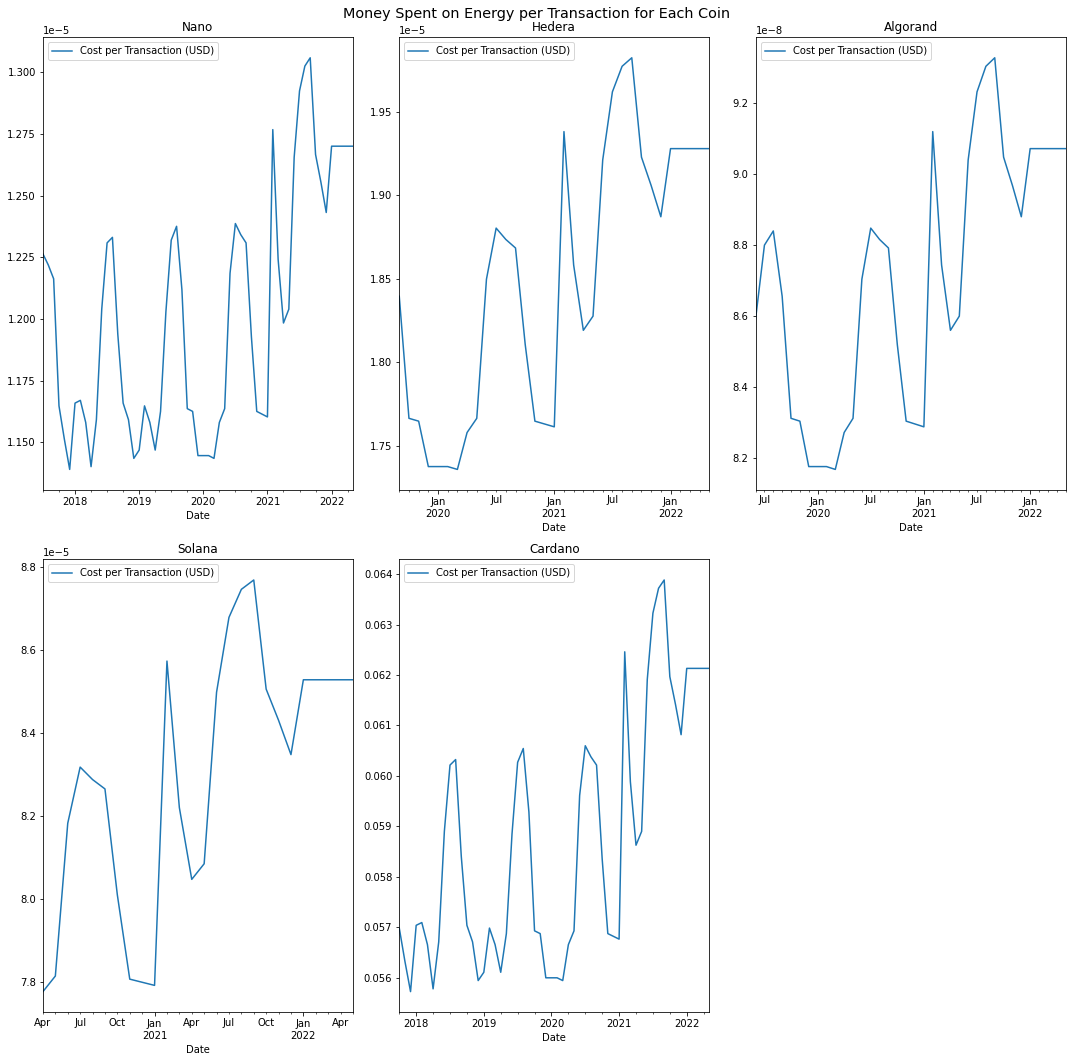

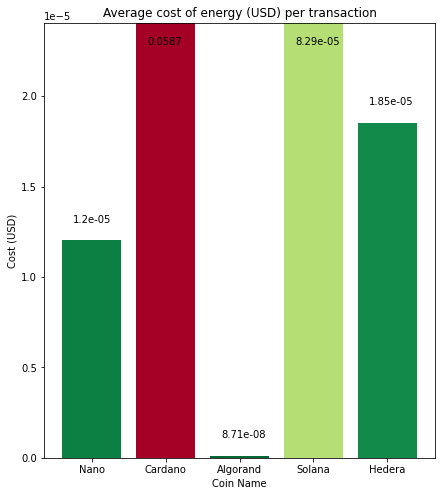

In [165]:
# Visualizations of coins cost data
fig, axes = plt.subplots(2, 3, figsize=(15,15))
plt.suptitle("Money Spent on Energy per Transaction for Each Coin", size='x-large')
for index, coin in enumerate(coins_dfs):
    coin.plot(ax=axes[index % 2, index % 3], x="Date", y="Cost per Transaction (USD)", kind="line", title=coin.name)
axes[1, 2].set_visible(False)
fig.tight_layout()
plt.show()


# Bar plot for averages
plt.figure(figsize=(7, 8))
coin_names = []
costs = []
for index, coin in enumerate(coins_dfs):
    coin_names.append(coin.name)
    costs.append(coin.avg_cost_per_tx)

cmap = cm.RdYlGn.reversed()
norm = Normalize(vmin=0, vmax=0.00025)
colors = []
for index, coin in enumerate(coins_dfs):
    colors.append(cmap(norm(coin.avg_cost_per_tx)))
    plt.text(index - 0.25, min([coin.avg_cost_per_tx + 0.000001, np.median(costs) * 1.3 * 0.95]), f'{coin.avg_cost_per_tx:.3g}')
plt.bar(coin_names, costs, color=colors)
plt.title("Average cost of energy (USD) per transaction")
plt.xlabel("Coin Name")
plt.ylabel("Cost (USD)")
plt.ylim(0, np.median(costs) * 1.3)
plt.show()

### Calculate carbon emissions per transaction

In [166]:
for coin in coins_dfs:
    merged = pd.merge_asof(coin, elec_emissions, on="Date")
    coin["Emissions per Transaction (Metric Tons CO2)"] = coin.kwh_per_tx * merged["Energy Emissions (Metric Tons CO2 / kWh)"]
    coin.avg_emissions_per_tx = np.mean(coin["Emissions per Transaction (Metric Tons CO2)"])

### Visualizations for carbon emissions per transaction

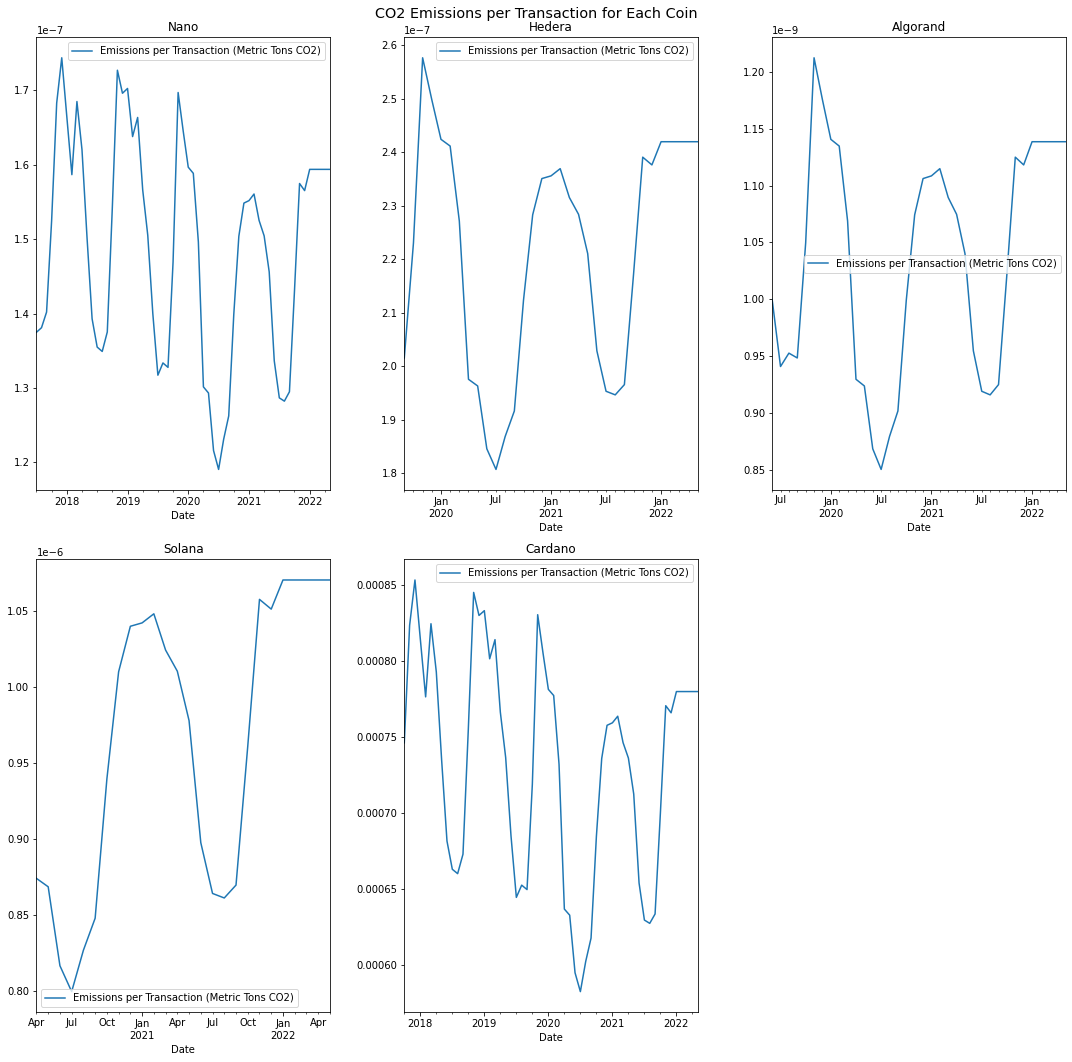

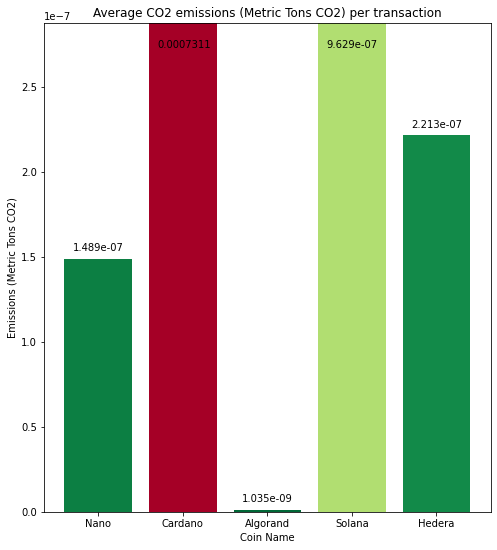

In [167]:
# Visualizations of coins emissions data
fig, axes = plt.subplots(2, 3, figsize=(15,15))
plt.suptitle("CO2 Emissions per Transaction for Each Coin", size='x-large')
for index, coin in enumerate(coins_dfs):
    coin.plot(ax=axes[index % 2, index % 3], x="Date", y="Emissions per Transaction (Metric Tons CO2)", kind="line", title=coin.name)
axes[1, 2].set_visible(False)
fig.tight_layout()
plt.show()

# Bar plot for averages
plt.figure(figsize=(8, 9))
coin_names = []
emission_vals = []
for index, coin in enumerate(coins_dfs):
    coin_names.append(coin.name)
    emission_vals.append(coin.avg_emissions_per_tx)

cmap = cm.RdYlGn.reversed()
norm = Normalize(vmin=0, vmax=0.000003)
colors = []
for index, coin in enumerate(coins_dfs):
    colors.append(cmap(norm(coin.avg_emissions_per_tx)))
    plt.text(index - 0.3, min([coin.avg_emissions_per_tx + 0.000000005, np.median(emission_vals) * 1.3 * 0.95]), f'{coin.avg_emissions_per_tx:.4g}')
plt.bar(coin_names, emission_vals, color=colors)
plt.title("Average CO2 emissions (Metric Tons CO2) per transaction")
plt.xlabel("Coin Name")
plt.ylabel("Emissions (Metric Tons CO2)")
plt.ylim(0, np.median(emission_vals) * 1.3)
plt.show()

### Compute climate damages (externalities)

In [168]:
for coin in coins_dfs:
    coin["Climate Damages (USD)"] = scc * coin["Emissions per Transaction (Metric Tons CO2)"]

### Compute net social value
Net social value = coin price - (electricity price * electricity per transaction) - damages per transaction

In [171]:
for coin in coins_dfs:
    coin["Net Social Value (USD)"] = coin["Price (USD)"] - coin["Cost per Transaction (USD)"] - coin["Climate Damages (USD)"]
    coin["Net Social Value (%)"] = (coin["Net Social Value (USD)"] / coin["Price (USD)"]) * 100


### Visualizations for net social value

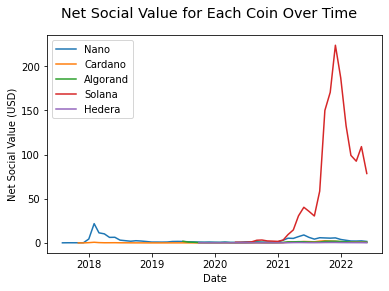

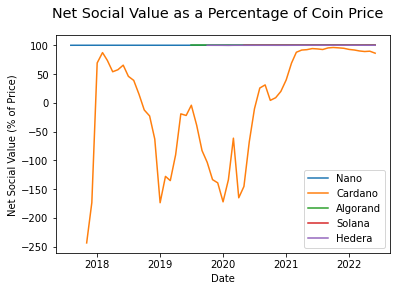

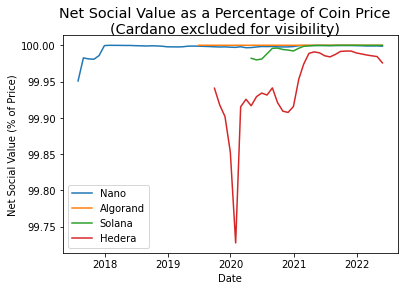

In [177]:
# Visualizations of coins net social value data
plt.suptitle("Net Social Value for Each Coin Over Time", size='x-large')
for index, coin in enumerate(coins_dfs):
    plt.plot(coin["Date"], coin["Net Social Value (USD)"], label=coin.name)
plt.legend()
plt.ylabel("Net Social Value (USD)")
plt.xlabel("Date")
plt.show()      

plt.suptitle("Net Social Value as a Percentage of Coin Price", size='x-large')
for index, coin in enumerate(coins_dfs):
    plt.plot(coin["Date"], coin["Net Social Value (%)"], label=coin.name)
plt.legend()
plt.ylabel("Net Social Value (% of Price)")
plt.xlabel("Date")
plt.show()    

plt.suptitle("Net Social Value as a Percentage of Coin Price\n(Cardano excluded for visibility)", size='x-large')
for index, coin in enumerate(coins_dfs):
    if(coin.name != "Cardano"):
        plt.plot(coin["Date"], coin["Net Social Value (%)"], label=coin.name)
plt.legend()
plt.ylabel("Net Social Value (% of Price)")
plt.xlabel("Date")
plt.show()  